## import modules

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

---

## load data to pandas dataframe

In [2]:
path_dir = './log2'
file_list = os.listdir(path_dir)
file_list.sort()
data = pd.DataFrame()
for file in file_list:
    now = pd.read_csv(f'./{file}', sep='\r\s', header=None, engine='python')
    data = pd.concat([data,now])
data[['date', 'time','loglevel' ,'serviceID', 'message']] = data[0].str.split(' ', n=4, expand=True)
warnings.filterwarnings(action='ignore')
data.describe()

,0,date,time,loglevel,serviceID,message
count,171,171,171,171,171,171
unique,171,2,35,2,2,101
top,03/08/2020 15:36:59 [1] 30-Normal: Autodetect ...,03/08/2020,15:37:12,[1],30-Normal:,Index connection granted to: 127.0.0.1
freq,1,164,14,135,168,17


---

## assign index and datetime

In [3]:
data['datetime'] = data['date'] + data['time']
data['timestamp'] = pd.to_datetime(data['datetime'], format="%d/%m/%Y%H:%M:%S")
data.drop(columns=[0,'date','time','datetime'], inplace=True)
data.insert(0,'index', range(len(data)))
data.set_index('index',inplace=True)
data = data[['timestamp', 'serviceID', 'loglevel', 'message']]
data

,timestamp,serviceID,loglevel,message
index,,,,
0,2020-08-03 15:31:48,30-Normal:,[0],Index connection granted to: 127.0.0.1
1,2020-08-03 15:31:48,70-Error:,[0],POST data did not include #DREENDDATA
2,2020-08-03 15:31:48,30-Normal:,[0],Saved incomplete POST data to C:\MicroFocus\ID...
3,2020-08-03 15:32:20,30-Normal:,[0],Index connection granted to: 127.0.0.1
4,2020-08-03 15:32:20,70-Error:,[0],POST data did not include #DREENDDATA
...,...,...,...,...
166,2020-08-04 10:54:15,30-Normal:,[1],Index Queue Command: DREADD?C%3A%5CUsers%5CUSE...
167,2020-08-04 10:54:15,70-Error:,[1],"Indexing Error: Cannot open index file ""C:\Use..."
168,2020-08-04 10:54:15,30-Normal:,[1],Index command finished. Took 0.01 s


---

## extract command messages and processing time

In [4]:
took = data[data['message'].str.contains('Took')]
process = data.iloc[list(took.index-1)]
process.insert(4,'processtime', list(took['message']))
process['processtime'] = process['processtime'].str.replace('[^0-9.]','')
process['processtime'] = process['processtime'].str[1:]
process['processtime'] = pd.to_numeric(process['processtime'])
process.head()

,timestamp,serviceID,loglevel,message,processtime
index,,,,,
10,2020-08-03 15:33:16,30-Normal:,[1],Sync Mapped Files...Completed,0.01
23,2020-08-03 15:37:01,30-Normal:,[1],Done Indexing IndexID=5,1.91
39,2020-08-03 15:37:12,30-Normal:,[1],Done Indexing IndexID=6,0.18
59,2020-08-03 15:38:41,30-Normal:,[1],Sync Mapped Files...Completed,2.27
63,2020-08-03 15:44:16,30-Normal:,[1],Index Queue Command: DRECREATEDBASE?DREDbName=...,0.01


---

## extract inserts and updates

In [5]:
idx = process[process['message'].str.contains('Done Indexing')]
idx['document'] = list(data.iloc[list(idx.index-1)].message)
idx['document'] = idx['document'].str.replace('[^\d,]','')
idx[['insert', 'update']] = idx['document'].str.split(',', n=2, expand=True)
idx['insert'] = idx['insert'].str.replace('^\s*$', '0')
idx['update'].fillna(0,inplace = True)
idx['insert'] = pd.to_numeric(idx['insert'])
idx['update'] = pd.to_numeric(idx['update'])
idx.drop(columns='document',inplace=True)
idx.head()

,timestamp,serviceID,loglevel,message,processtime,insert,update
index,,,,,,,
23,2020-08-03 15:37:01,30-Normal:,[1],Done Indexing IndexID=5,1.91,1339,29
39,2020-08-03 15:37:12,30-Normal:,[1],Done Indexing IndexID=6,0.18,214,106
77,2020-08-03 15:44:46,30-Normal:,[1],Done Indexing IndexID=9,0.05,46,94
100,2020-08-03 16:01:27,30-Normal:,[1],Done Indexing IndexID=11,0.02,0,0
112,2020-08-03 16:01:34,30-Normal:,[1],Done Indexing IndexID=12,0.01,0,0


---

## group by hour

In [6]:
idx['timestamphour'] = idx['timestamp'].dt.hour
pivot = idx.pivot_table(values=['processtime', 'insert', 'update'], index='timestamphour' ,aggfunc=np.sum)
pivot['indexpersecond(docs/s)'] = ((pivot['insert'] + pivot['update']) / pivot['processtime']).astype(int)
pivot2 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.mean)
pivot3 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.max)
pivot4 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.min)
pivot5 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc='count')
pivot['processtimemean(s)'] = pivot2['processtime'].round(2)
pivot['processtimemax(s)'] = pivot3['processtime'].round(2)
pivot['processtimemin(s)'] = pivot4['processtime'].round(2)
pivot['count(cmds)'] = pivot5['processtime'].round(2)
new_index = ['insert','update','indexpersecond(docs/s)','processtime','processtimemean(s)','processtimemax(s)','processtimemin(s)','count(cmds)']
new_index_name = {'insert':'insertsum(docs)','update':'updatesum(docs)','processtime':'processtimesum(s)'}
pivot = pivot.reindex(new_index, axis='columns')
pivot.rename(new_index_name,axis='columns',inplace=True)
pivot

,insertsum(docs),updatesum(docs),indexpersecond(docs/s),processtimesum(s),processtimemean(s),processtimemax(s),processtimemin(s),count(cmds)
timestamphour,,,,,,,,
15,1599,229,854,2.14,0.71,1.91,0.05,3
16,0,0,0,0.06,0.01,0.02,0.01,5


---

## data visualization

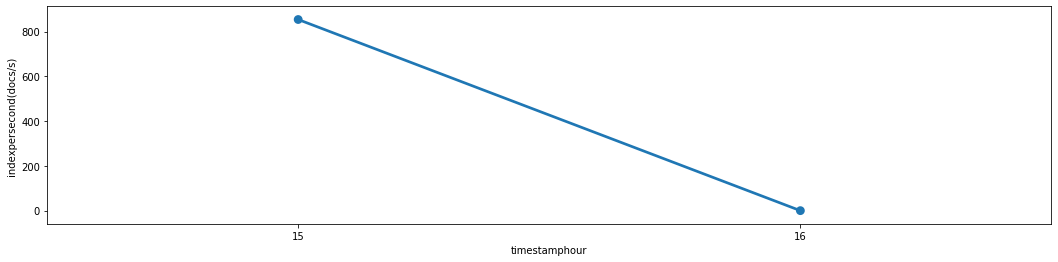

In [7]:
plt.figure(figsize=[18,4])

sns.pointplot(x=pivot.index, y='indexpersecond(docs/s)',data=pivot)

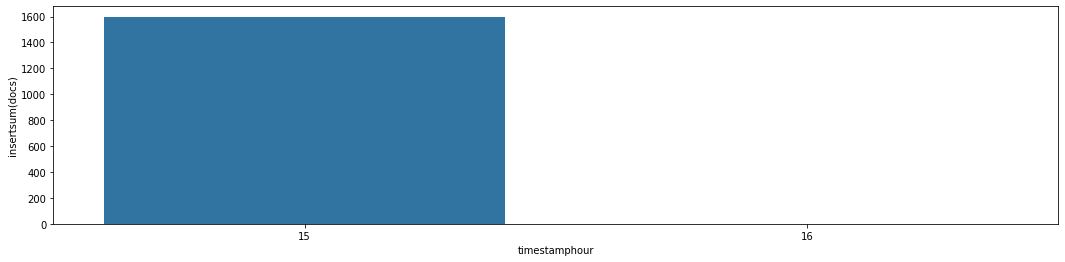

In [8]:
fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=pivot, x=pivot.index, y="insertsum(docs)", ax=ax3)

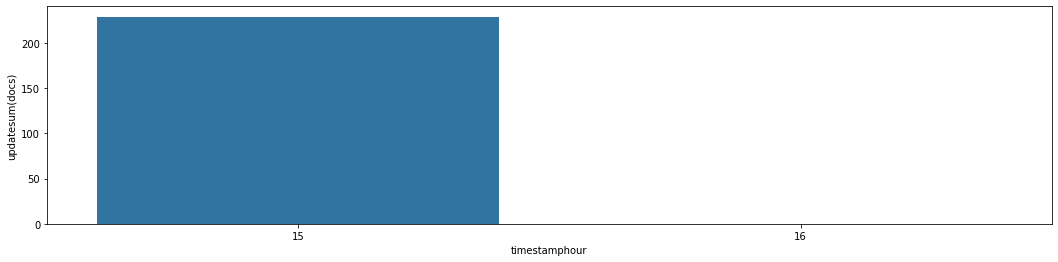

In [9]:
fig, ax4 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=pivot, x=pivot.index, y="updatesum(docs)", ax=ax4)